<a href="https://colab.research.google.com/github/AnetaKovacheva/ESRGAN/blob/main/Image_Enhancing_with_ESRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhance SoftUni logo images with ESRGAN

## Introduction

I was inspired to explore ESRGAN because I wanted to enhance low resolution images. I realised that publishing Data Science and Machine Learning related projects on my LinkedIn profile is not so effective. Instead, I decided to make my own web site where to describe my background, to show my skills, and to share my portfolio.

While I was working on the *Artificial Intelligence* section, it turned out that SoftUni's images used for decorating the courses in Artificial Intelligence are rather small - only 310 x 162 pixels. The framework I chose to do my web site needs larger images. Thus, I was faced with the problem how to enhance the ones I have.

A thorough research led me to ESRGAN - Enhanced Super Resolution Generative Adversarial Network - developed by Wang et. al.[1]. Their work is briefly presented in the first Chapter. Thereafter, in Chapter 2, SoftUni's images are enhanced with TensorFlow  implementation of ESRGAN[2]. The model is downloadable from TensorFlow Hub[3] - a repository of trained machine learning models ready for fine-tuning and deployable anywhere.





## 1. Brief overview of ESRGAN

It is important to briefly explain what GAN is. Developed in 2014 by Ian Goodfellow et al., Generative Adversarial Networks enable the generation of fairly realistic synthetic images by forcing the generated images to be statistically almost indistinguishable from real ones. GANs are made of two parts: - Generator: it takes as input a random vector (a random point in the
latent space), and decodes it into a synthetic image; and - Discriminator (or adversary): it takes as input an image (real or synthetic), and predicts whether the image came from the training set or was created by the Generator network. The Generator network is trained to be able to fool the Discriminator, and
thus it evolves toward generating increasingly realistic images as training goes on: artificial images that look indistinguishable from real ones, to the extent that it’s impossible for the Discriminator to tell the two apart [4].

Ian Goodfellow et al. work inspired other scientists to experiment with GANs. Super-Resolution Generative Adversarial Network is capable of generating realistic textures during single image super-resolution[1]. However, Wang et al. remind that the hallucinated details are often accompanied with unpleasant artifacts. To further enhance the visual quality, they study three key components of SRGAN - network architecture, adversarial loss and perceptual loss, and improve each of them to derive an Enhanced SRGAN (ESRGAN). 

In particular, they introduce the Residual-in-Residual Dense Block (RRDB) (see below) without batch normalization as the basic network building unit. They borrow the idea from relativistic GAN to let the Discriminator predict relative realness instead of the absolute value. Finally, they improve the perceptual loss by using the features before activation, which could provide
stronger supervision for brightness consistency and texture recovery.




Fig. 1. *Left*: Removed BN layers in residual block in SRGAN. *Right*: RRDB block is used in the deeper model and is the residual scaling parameter.

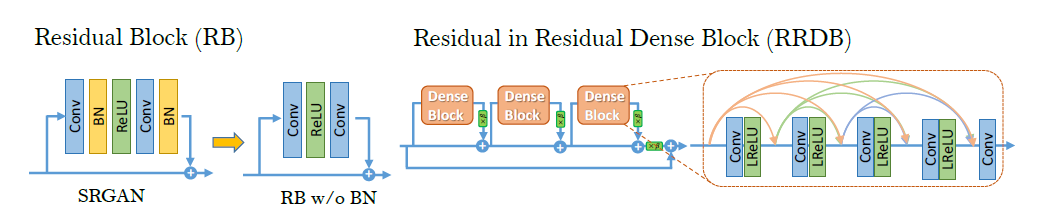

*Source*: Wang et. al.: ESRGAN: Enhanced Super- Generative Adversarial Networks

It turned out that these improvements make the proposed ESRGAN to achieve consistently better visual quality with more realistic and natural textures than SRGAN. 

It should be noted that Wang et. al.  with their work on ESRGAN won the 1-rst place in the [PIRM 2018-SR Challenge](https://pirm.github.io/).

## 2. Enhance SoftUni logo images with ESRGAN

### Imports

In [1]:
%matplotlib inline

In [2]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image

### 2.1. Load low resolution images

Paths to low resolution images are stored in a separate constant. These are the images of size 310 x 162 pixels that need to be enhanced.

In [3]:
MATH_PATH = "/content/drive/MyDrive/ESRGAN/Math_softuni.jpg"
DATA_SCIENCE_PATH = "/content/drive/MyDrive/ESRGAN/DS_softuni.png"
ML_PATH = "/content/drive/MyDrive/ESRGAN/ML_softuni.jpg"
DL_PATH = "/content/drive/MyDrive/ESRGAN/DL_softuni.jpg"

The path to the ESRGAN model on TensorFlow Hub was stored in another constant. It is explained that ESRGAN produces 4 times Super Resolution Image from images of {Height, Width} >=64. It works best on Bicubically downsampled images, because, the model is originally trained on Bicubically Downsampled DIV2K Dataset. 

In [4]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

### 2.2. Define Helper Functions

#### 2.2.1. Preprocess image

The images need to be preprocessed before being fed through the network. All preliminary transformations are performed by the function below. 

The first line `tf.image.decode_image(tf.io.read_file(IMAGE_PATH))` detects whether an image is a BMP, GIF, JPEG, or PNG, and performs the appropriate operation to convert the input bytes string into a Tensor of type dtype. `tf.io.read_file` reads the contents of a file. This operation returns a Tensor with the 
entire contents of the input filename. It does not do any parsing, it just returns the contents as they are.


The next two lines
  
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]

check image type, and if PNG, removes the alpha channel (a color component that represents the degree of transparency (or opacity) of a color). The model only supports images with 3 color channels.


`tf.convert_to_tensor` converts Python objects of various types to Tensor objects. It accepts Tensor objects, numpy arrays, Python lists, and Python scalars. In this case, the shape is divided by 4 and then multiplied by 4 to preserve the ratio between image height and width.

The next line of code (`tf.image.crop_to_bounding_box()`) crops the image to a specified bounding box. This step cuts a rectangular bounding box out of image. The top-left corner of the bounding box is at offset_height, offset_width in image, and the lower-right corner is at offset_height + target_height, offset_width + target_width. In this example, *offset_height* and *offset_width* are zeros; image shapes are target height and width, respectively, and are added to offset values.

ESRGAN authors remind that the image values must be of float32 type, converted with `tf.cast(image, tf.float32)`.

The function returns a TensorFlow object of 4 dimensions (by applying `tf.expand_dims()`: batch size, image height, image width, color channels. 


In [5]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
      Returns:
        4D Tensor
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)


#### 2.2.2. Save image

Another helper function used in this example is `save_image()`. It saves the unscaled Tensor Image to a jpg file. In case pixel values are not RGB compatible, these are re-computed. The `isinstance()` function returns *True* if the specified object (image) is of the specified type, otherwise the response is *False*. Lastly, pixel values are converted from `tf.float32` to `tf.uint8` type. The latter are unsigned integers of 8 bits. A uint8 data type contains all whole numbers from 0 to 255. As with all unsigned numbers, the values must be non-negative. Uint8's are mostly used in graphics since colors are always non-negative ([uint8 explained](https://www.cs.utah.edu/~germain/PPS/Topics/Matlab/uint8.html)). 

In [6]:
def save_image(image, filename):
  """
  Saves unscaled Tensor Images.
  Args:
    image: 3D image tensor [height, width, channels]
    filename: Name of the file to save.
  """

  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)


#### 2.2.3. Plot image

A third function plot images from image tensors. It expects a 3D image tensor and the image title. `np.asarray()` converts the input tensor values to an array. Next, `tf.clip_by_value` clips tensor values to a specified min and max. Thereafter, `Image.fromarray()` creates an image memory from an object exporting the array interface (by using the buffer protocol). Lastly, the image is displayed by applying `plt.imshow()`. 

In [7]:
def plot_image(image, title = ""):
  """
  Plots images from image tensors.
  Args:
    image: 3D image tensor [height, width, channels]
    title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())

  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

### 2.3. Enhance image with ESRGAN

#### 2.3.1. Display original images

All four SoftUni images are simultaneously loaded and preprocessed.

In [8]:
math_image = preprocess_image(MATH_PATH)
ds_image = preprocess_image(DATA_SCIENCE_PATH)
ml_image = preprocess_image(ML_PATH)
dl_image = preprocess_image(DL_PATH)

A brief check confirms the image pixel values are converted and stored as 4D tensors of float32 type.

In [9]:
math_image

<tf.Tensor: shape=(1, 160, 308, 3), dtype=float32, numpy=
array([[[[255., 159.,   0.],
         [255., 159.,   0.],
         [255., 159.,   0.],
         ...,
         [252., 160.,   0.],
         [252., 160.,   0.],
         [252., 160.,   0.]],

        [[255., 159.,   0.],
         [255., 159.,   0.],
         [255., 159.,   0.],
         ...,
         [253., 160.,   0.],
         [255., 158.,   0.],
         [253., 160.,   0.]],

        [[255., 159.,   0.],
         [255., 159.,   0.],
         [255., 159.,   0.],
         ...,
         [255., 158.,   0.],
         [255., 157.,   0.],
         [255., 158.,   0.]],

        ...,

        [[255., 159.,   0.],
         [255., 159.,   0.],
         [255., 159.,   0.],
         ...,
         [255., 159.,   0.],
         [255., 159.,   0.],
         [255., 159.,   0.]],

        [[255., 159.,   0.],
         [255., 159.,   0.],
         [255., 159.,   0.],
         ...,
         [255., 159.,   0.],
         [255., 159.,   0.],
         

All four original (low resolution) images are plotted below.

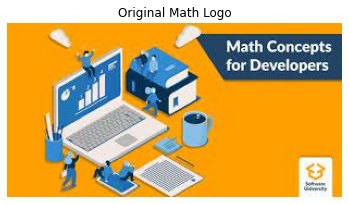

In [10]:
plot_image(tf.squeeze(math_image), title = "Original Math Logo")

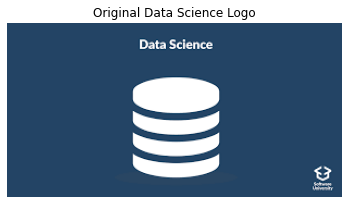

In [11]:
plot_image(tf.squeeze(ds_image), title = "Original Data Science Logo")

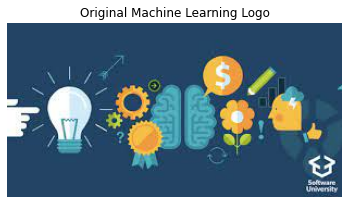

In [12]:
plot_image(tf.squeeze(ml_image), title = "Original Machine Learning Logo")

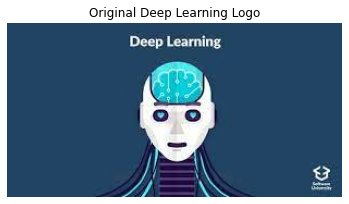

In [13]:
plot_image(tf.squeeze(dl_image), title = "Original Deep Learning Logo")

#### 2.3.2. Load ESRGAN model

ESRGAN model is available for loading and downloading from TensorFlow Hub ([ESRGAN](https://tfhub.dev/captain-pool/esrgan-tf2/1)). First, it is downloaded and thereafter loaded with Keras API. Nonetheless, applying `summary()` over the model does not reveal its architecture. The output indicates that the main "layer" is RRDBNet model.

In [14]:
model_saved = tf.keras.models.load_model('/content/drive/MyDrive/ESRGAN/saved_model')

In [15]:
model_saved.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_0 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 rrdb_net (RRDBNet)          multiple                  38755     
                                                                 
Total params: 38,755
Trainable params: 38,755
Non-trainable params: 0
_________________________________________________________________


For this reason, the model is loaded via its path to TensorFlow Hub.

In [16]:
model = hub.load(SAVED_MODEL_PATH)

#### 2.3.3. Make Super Resolution Images

A separate function (see below) creates, plots, and saves the enhanced image. Enhancing time is computed as well. The low resolution image is fed through the model, which enlarges its height and width. Thereafter, `tf.squeeze()` removes the 0-dimension (batches). 

`plot_image()` displays, and `save_image()` saves the high resolution (enhanced) image. Both will use the string provided as title for their output - an image, and a file.

In [17]:
def make_super_resolution_image(image, title):
  """
  Creates, plots and saves super (high) resolution images.
  Args:
    image: 4D image tensor [batch, height, width, channels]
    title: Title to display on the plot.
  """
  start = time.time()
  fake_image = model(image)
  fake_image = tf.squeeze(fake_image)
  print("Time taken: %f" % (time.time() - start))

  # Plot Super resolution image
  plot_image(fake_image, title = title)
  save_image(fake_image, filename = title)

Time taken: 12.500339
Saved as Math Super Resolution.jpg


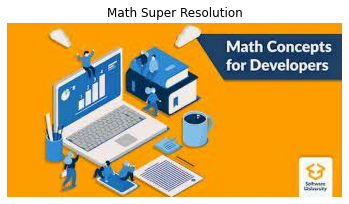

In [18]:
make_super_resolution_image(math_image, "Math Super Resolution")

Time taken: 11.448476
Saved as Data Science Super Resolution.jpg


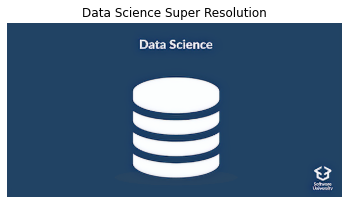

In [19]:
make_super_resolution_image(ds_image, "Data Science Super Resolution")

Time taken: 11.527103
Saved as Machine Learning Super Resolution.jpg


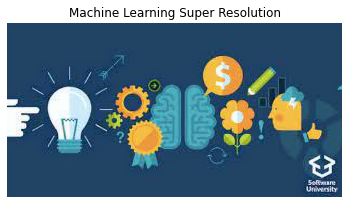

In [20]:
make_super_resolution_image(ml_image, "Machine Learning Super Resolution")

Time taken: 11.533063
Saved as Deep Learning Super Resolution.jpg


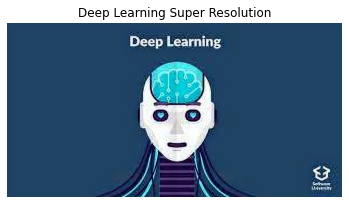

In [21]:
make_super_resolution_image(dl_image, "Deep Learning Super Resolution")

ESRGAN needs around 10 seconds (CPU runtime) to make an image 4 times larger. Its quality is far from perfect but still is better than simply stretching out low resolution picture.

### References:
[1] Wang et. al. (2018). ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks, arXiv:1809.00219v2 [cs.CV]

[2] TensorFlow, Resources, Hub, Tutorials: [Image Super Resolution using ESRGAN](https://www.tensorflow.org/hub/tutorials/image_enhancing).

[3] ESRGAN-tf2 - download model: https://tfhub.dev/captain-pool/esrgan-tf2/1.

[4] François Chollet (2018). Deep Learning with Python.